<img src="https://raw.githubusercontent.com/pangeo-data/pangeo.io/refs/heads/main/public/Pangeo-assets/pangeo_logo.png"
     alt="Pangeo logo"
     style="float: center; margin-right: 10px;" />

# 3.3 Data Sharing with Pangeo

Science becomes significantly more impactful when it is shared. Therefore, we will learn how to open up our scientific output from a cloud platform to ensure it is Findable, Accessible, Interoperable, and Reusable (FAIR), maximizing its potential to contribute to broader research and applications.

TWe will follow these steps:

- Reuse the workflow previously used to create the snow-covered area.
- Select the Area of Interest (AOI).
- Download results for a single time-step:
    - A Snow Cover Area map in the COG (Cloud Optimized GeoTIFF) format.
    - A STAC (SpatioTemporal Asset Catalog) metadata item generated using the Pangeo ecosystem.
- Adapt the STAC metadata item to include standardized and machine-readable metadata, improving its findability and interoperability.
- Upload the results and make them openly available via:
    - A STAC browser to enhance searchability and accessibility.
    - A web map to facilitate visualization and usability for a wide range of stakeholders.

By ensuring the data is as compliant as possible with the FAIR principles, we aim to make it easier for researchers, policymakers, and other stakeholders to discover, access, and build upon the scientific outputs.

## Libraries

Start by creating the folders and data files needed to complete the exercise

In [ ]:
!cp -r $DATA_PATH/33_results/ $HOME/

In [ ]:
!cp $DATA_PATH/_33_pangeo_utilities.py $HOME/

In [1]:
import json
import os
import subprocess
from datetime import datetime, timezone

import numpy as np

import ipyleaflet

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import pystac_client
import pystac

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import rioxarray as rio
import xarray

from _33_pangeo_utilities import (
    calculate_sca,
    create_bounding_box,
    extract_metadata_geometry, 
    extract_metadata_time,
    extract_metadata_stac, 
)

## Select an Area of Interest and Time Frame

Start by selecting a center point of the area you would like to analyse from the map shown below. The starting extent is the full Alps. Zoom in to an area and choose a region that has not been mapped yet. *Make sure not to overlap too much with already mapped areas by having a look at the [STAC Collection](https://esa.pages.eox.at/cubes-and-clouds-catalog/browser/#/?.language=en)*. It's a community mapping project :)
Create a 1 km bounding box around it. This will be the area you are calculating the snow covered area for. 

<div class="alert alert-block alert-warning">
    <b>Attention:</b>
 Execute the cell below to show the map. Zoom to a location you want to analyze. Use the location symbol to select a point. A marker appears on the map. This is the center of your area of interest
</div>

In [ ]:
m = ipyleaflet.Map(
    center=(47.005, 11.507),
    zoom=7.5)

draw_control = ipyleaflet.DrawControl()

m.add(draw_control)
m

**Attention:**
 Now this cell will get the coordinates of the marker you have placed. This will create a 1 km bounding box around the chosen location. And visualize it in the map above. *The marker moves to the center when you zoom in*

### Create a bounding box once the location of interest is selected

In [ ]:
geom = draw_control.last_draw["geometry"]['coordinates']

# set distance of 1 km around bbox
distance_km = 1

# Create a bounding box around the point
bbox = create_bounding_box(geom[0], geom[1], distance_km)
bbox

We generate a polygon from the list points and add it on the map

In [ ]:
# Create polygon from lists of points
polygon = ipyleaflet.Polygon(
    locations=[(bbox[1], bbox[0]), (bbox[3], bbox[0]), (bbox[3], bbox[2]),(bbox[1], bbox[2])],
    color="green",
    fill_color="green"
)

# Add the polygon to the map
m.add(polygon);

Now we'll select the time frame. We'll start with the winter months of 2023. 

In [ ]:
temporal_extent = ["2018-02-01", "2018-06-01"]

## Reuse the function to compute the snow covered area data cube

To enhance reusability and streamline our workflow, we've encapsulated the Python code used to create the snow-covered area data cube into a reusable function, `calculate_sca()`. This function is stored in the `_33_pangeo_utilities.py` module.

The function generates a three-dimensional data cube with the dimensions x, y, and time. By exposing key parameters to the function, specifically the bounding box and temporal extent, we've made it easy to adapt the function to different scenarios. For this exercise, we will update these parameters based on the choices we've made above.

### Why Create Functions?
Creating reusable functions like `calculate_sca()` is a best practice in Python for several reasons:
- Improved Reusability: Functions allow you to reuse the same logic across multiple projects or analyses, reducing the need to rewrite code.
- Modularity: Encapsulating code in functions helps organize scripts into logical sections, making them easier to understand and maintain.
- Error Reduction: Reusing a thoroughly tested function minimizes the risk of introducing errors in your code.
- Adaptability: Exposing parameters like the bounding box and temporal extent allows you to customize the function for different datasets or regions without modifying the core logic.

By following this approach, we create more flexible, maintainable, and scalable workflows that can be easily shared with others or reused in future projects.

We will call the function with the bounding box and temporal extent we chose above. 

In [ ]:
snow_map_3dcube = calculate_sca(bbox, temporal_extent)
snow_map_3dcube

## Reduce the time dimension

To calculate the Snow-Covered Area (SCA) for the winter period of a given year, we need to reduce the values along the time dimension. Using `Xarray`, we achieve this by applying the `median()` operation along the time axis.

Instead of performing the computation immediately, we leverage lazy loading in `Xarray`, which allows us to build a process graph that defines the computation steps without executing them. This approach optimizes memory usage and efficiency, as the computation will only be executed when explicitly triggered.

In [ ]:
snow_map_2dcube = snow_map_3dcube.median(["time"])
snow_map_2dcube

Additionally, we update the metadata associated with the data to ensure that it remains accurate and informative throughout the process. By directly building upon the process graph we loaded earlier, we incrementally prepare the computation while keeping the workflow efficient and modular.
We add attributes such as statistics to the dataset, such as a summary of the values within the dataset and also some metadata, i.e. the legend (TIFFTAGS).  And we reduce the datatype to the lowest possible datatype supported by COG uint8, since only have three values to represent (0, 1, 2).

In [ ]:
snow_map_2dcube = snow_map_2dcube.rename("snow_covered_area")
snow_map_2dcube = snow_map_2dcube.astype("uint8")

In [ ]:
snow_map_2dcube.attrs["TIFFTAG_IMAGEDESCRIPTION"] = "SnowCoveredArea_0=nosnow_1=snow_2-nodatavalue=cloud"
snow_map_2dcube.attrs["STATISTICS_MAXIMUM"] = 1
snow_map_2dcube.attrs["STATISTICS_MEAN"] = 1
snow_map_2dcube.attrs["STATISTICS_MINIMUM"] = 1
snow_map_2dcube.attrs["STATISTICS_STDDEV"] = 0
snow_map_2dcube.attrs["_FillValue"] = 2
snow_map_2dcube.attrs["scale_factor"] = 1
snow_map_2dcube.attrs["add_offset"] = 0
snow_map_2dcube.attrs["long_name"] = "Snow Covered Area" 
snow_map_2dcube.attrs["temporal_extent"] = temporal_extent[0].replace("-","/") + "-" + temporal_extent[1].replace("-","/")
snow_map_2dcube.attrs["spatial_extent"] =  json.dumps({"crs": 4326,
                                            "east": bbox[2],
                                            "north": bbox[3],
                                            "south": bbox[1],
                                            "west": bbox[0]})

## Save the result locally

With the process graph complete, we can now compute the results and save them to a file in the `GTiff` format, which automatically generates a Cloud Optimized GeoTIFF (COG) for efficient storage and access.

In [ ]:
snow_map_2dcube.rio.to_raster("33_results/snowmap_cog_pangeo_uint8.tif", driver="COG")

## Open, load results, and create STAC catalog to share results
Now we can open the COG and visualize it. 

In [2]:
snowmap = rio.open_rasterio("33_results/snowmap_cog_pangeo_uint8_2.tif", decode_coords="all")
snowmap

<xarray.DataArray (band: 1, y: 210, x: 143)>
[30030 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.935e+05 6.935e+05 ... 6.949e+05 6.949e+05
  * y            (y) float64 5.252e+06 5.251e+06 ... 5.249e+06 5.249e+06
    spatial_ref  int64 0
Attributes:
    long_name:                 Snow Covered Area
    spatial_extent:            {"crs": 4326, "east": 11.582146216059186, "nor...
    STATISTICS_MAXIMUM:        1
    STATISTICS_MEAN:           1
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         0
    temporal_extent:           2018/02/01-2018/06/01
    TIFFTAG_IMAGEDESCRIPTION:  SnowCoveredArea_0=nosnow_1=snow_2-nodatavalue=...
    _FillValue:                2
    scale_factor:              1.0
    add_offset:                0.0

Now, we check if the nodata value can be determined directly from the COG metadata

Now, we make a plot of the snowmap keeping in mind that `0 = no snow`, `1 = snow`, and `2 = clouds (nodata value)`

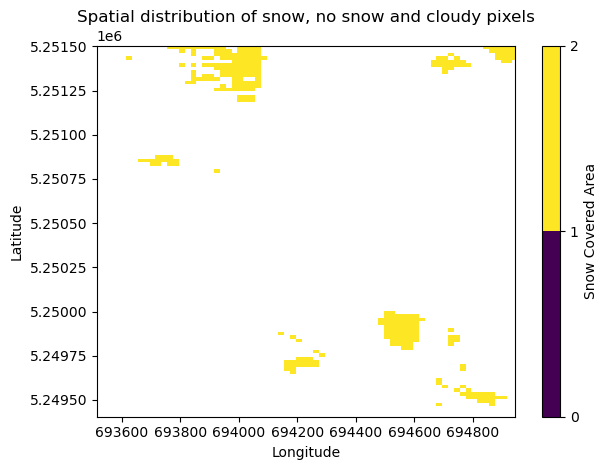

In [3]:
snowmap.plot(levels=[0, 1, 2])
plt.title("Spatial distribution of snow, no snow and cloudy pixels")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.tight_layout()

Let's have a look at the histogram to understand the distribution of the values in our map

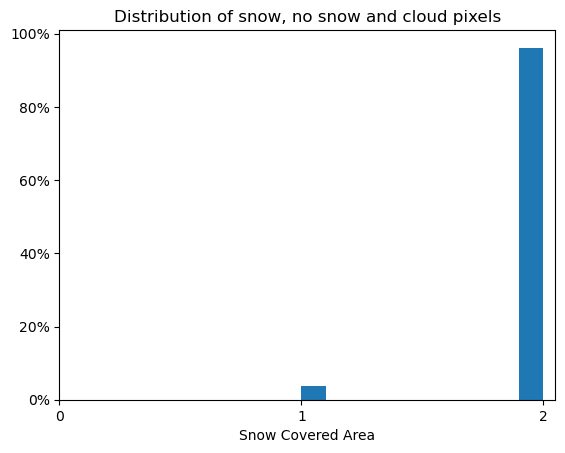

In [4]:
data = snowmap.values.flatten()
snowmap.plot.hist(xticks = [0, 1, 2], weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Distribution of snow, no snow and cloud pixels")
plt.show()

## Adding STAC metadata
In addition to the COG we also need to STAC metadata for our result.
Let's have a look at the metadata from the snowmap dataset

In [5]:
snowmap.attrs

{'long_name': 'Snow Covered Area',
 'spatial_extent': '{"crs": 4326, "east": 11.582146216059186, "north": 47.38778084824125, "south": 47.36942115175876, "west": 11.564159783940813}',
 'STATISTICS_MAXIMUM': 1,
 'STATISTICS_MEAN': 1,
 'STATISTICS_MINIMUM': 1,
 'STATISTICS_STDDEV': 0,
 'temporal_extent': '2018/02/01-2018/06/01',
 'TIFFTAG_IMAGEDESCRIPTION': 'SnowCoveredArea_0=nosnow_1=snow_2-nodatavalue=cloud',
 '_FillValue': 2,
 'scale_factor': 1.0,
 'add_offset': 0.0}

#### Adding Providers and Author of the data

Add your information to become visible as author of the data -  description of each field can be found here: https://github.com/radiantearth/stac-spec/blob/master/commons/common-metadata.md#provider-object

Please note that leaving the field empty will lead to failed validation of STAC item

<div class="alert alert-block alert-warning">
    <b>Attention</b>: Enter your full name and a short description of the snowmap you generated e.g. `name = "Jane Doe"` and `description = "snow map of Merano"`
</div>

In [6]:
name = "Anne Fouilloux"
description = "Snow map generated with the Pangeo ecosystem"

In [7]:
# generate timestamp
datetime_utc = datetime.now(tz=timezone.utc)
ts = datetime_utc.isoformat().split("T")[0]

author = [{
    "name": name,
    "description": description,
    "roles": ["processor"],
}]

providers = author

author_id = [name[:2] for name in author[0]["name"].split(" ")]

start_time, end_time = snowmap.attrs["temporal_extent"].split("-")

spatial_extent = json.loads(snowmap.attrs["spatial_extent"])
footprint = {"type": "Polygon", "coordinates": [[
    [spatial_extent["west"], spatial_extent["south"]],
    [spatial_extent["east"], spatial_extent["south"]],
    [spatial_extent["east"], spatial_extent["north"]],
    [spatial_extent["west"], spatial_extent["north"]],
    [spatial_extent["west"], spatial_extent["south"]] ]]}

bbox = (spatial_extent["west"], spatial_extent["south"], 
        spatial_extent["east"], spatial_extent["north"])

temporal_extent = [start_time.replace("/","-"), end_time.replace("/","-")]

data_providers, links = extract_metadata_stac(bbox, temporal_extent)

properties = { "providers" : providers }

class pystac.item.Item(id: str, geometry: dict[str, Any] | None, bbox: list[float] | None, datetime: Datetime | None, properties: dict[str, Any], start_datetime: Datetime | None = None, end_datetime: Datetime | None = None, stac_extensions: list[str] | None = None, href: str | None = None, collection: str | Collection | None = None, extra_fields: dict[str, Any] | None = None, assets: dict[str, Asset] | None = None)[source]


In [8]:
new_item = pystac.Item(id="snowcover_" + "".join(author_id).lower()+ "_" + str(ts),
                       geometry=footprint,
                       bbox=bbox,
                       datetime=None,
                       start_datetime=datetime.strptime(start_time, '%Y/%m/%d'),
                       end_datetime=datetime.strptime(end_time, '%Y/%m/%d'),
                       properties=properties)
new_item

<Item id=snowcover_anfo_2025-01-01>

### Add Asset and all its information to Item 

In [9]:
new_item.add_asset(
    key="image",
    asset=pystac.Asset(
        href="snowmap_cog_pangeo_uint8.tif",
        media_type=pystac.MediaType.COG,
        title = "Snow coverage",
        roles=["data"]
    )
)

In [10]:
new_item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'snowcover_anfo_2025-01-01',
 'properties': {'providers': [{'name': 'Anne Fouilloux',
    'description': 'Snow map generated with the Pangeo ecosystem',
    'roles': ['processor']}],
  'start_datetime': '2018-02-01T00:00:00Z',
  'end_datetime': '2018-06-01T00:00:00Z',
  'datetime': None},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[11.564159783940813, 47.36942115175876],
    [11.582146216059186, 47.36942115175876],
    [11.582146216059186, 47.38778084824125],
    [11.564159783940813, 47.38778084824125],
    [11.564159783940813, 47.36942115175876]]]},
 'links': [],
 'assets': {'image': {'href': 'snowmap_cog_pangeo_uint8.tif',
   'type': image/tiff; application=geotiff; profile=cloud-optimized,
   'title': 'Snow coverage',
   'roles': ['data']}},
 'bbox': (11.564159783940813,
  47.36942115175876,
  11.582146216059186,
  47.38778084824125),
 'stac_extensions': []}

### Saving the resulting item as stac_item.json into results folder

In [11]:
stac_json = json.dumps(new_item.to_dict())
with open("33_results/stac_item.json", "w") as file:
    file.write(stac_json)

### Validation of the STAC item

Validating that STAC item is important - non valid STAC will not be displayed in the STAC browser after upload

In [12]:
from stac_validator import stac_validator
import requests
stac = stac_validator.StacValidate()
f = open('33_results/stac_item.json')
data = json.load(f)
stac.validate_dict(data)
print(stac.message)

[{'version': '1.0.0', 'path': None, 'schema': ['https://schemas.stacspec.org/v1.0.0/item-spec/json-schema/item.json'], 'valid_stac': True, 'asset_type': 'ITEM', 'validation_method': 'default'}]


<div class="alert alert-block alert-warning">
    <b>Attention</b>: Check if `valid_stac` is True. If not, check you have filled the author and description properly.
</div>

### Now it is time to upload solution to the submission folder and make results visible in STAC browser

Upload both the STAC json file and the final .tif file to "submissions" folder in your home directory

You can use the code below to copy the results to the submissions folder

In [ ]:
!cp ./33_results/stac_item.json ~/submissions/
!cp ./33_results/snowmap_cog_pangeo_uint8.tif ~/submissions/

And now by executing the cell below, update of the STAC browser will start. By this, you are uploading your results to the openly available STAC browser. This might take some minutes.

In [ ]:
env_var1 = os.getenv('EMAIL')
curl_command = f"curl -X POST -F token=glptt-42d31ac6f592a9e321d0e4877e654dc50dcf4854 -F ref=main -F 'variables[USER_DIRECTORY]=\"{env_var1}\"' https://gitlab.eox.at/api/v4/projects/554/trigger/pipeline" 
process = subprocess.Popen(curl_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

### Your results are online!
You can now browse your results together with all the other submissions at the publicly available STAC Catalog! You can check your snow cover map, that you are correctly listed as the author and that your contribution has the correct name. The license on the STAC Collection "Cubes and Clouds: Snow Cover" is CC-BY-4.0. The STAC Collection also has it's own DOI.

Congratulations you have just contributed to a community mapping project that is completely open source, open data and FAIR! Make sure to show it also to your friends, colleagues or potential employers :)

https://esa.pages.eox.at/cubes-and-clouds-catalog/browser/#/?.language=en

If you would like to redo your submission, you can still update your files in submissions folder and once ready, run again the code in the cell above. 

**Attention:** If you have previously opened the STAC browser, your old submission will be cached and not directly displayed. To circumvent this, open a private window from your browser.

Happy coding!